# APAM 4990 Final Project

## Group Member

- Hangyu Tian, ht2459
- Jinrong Cao, jc4515
- Jo Wei Lee, jl5047
- Weihao Xu, wx2203


## Project Pipeline
- Load & Clean the Data
- Create New Features
- Remove Outliers
- EDA through Tableau
- Train the Model
- Make Predictions
- Tune Parameters to Increase Confidence


In [258]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from haversine import haversine
from math import pi, sin, cos
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForest
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error,mean_squared_log_error , r2_score

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import os
import time
import datetime
import missingno as msno
import scipy
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## 1.Data Loading & Cleaning 

The objective of the project is to build a model that accurately predicts the travel time (in seconds) for a taxi ride in New York City. We obtained the train set for year 2016 from Google BigQuery and noticed outliers that required first-step cleaning. Below are the data we excluded:

- Null data
- Pickup and dropoff location outside and far away from NYC 
- Total amount of fare that is 0
- Fare amount smaller than $2.5, since $2.5 is the beginning fare charged 
- Trip distance that is 0
- Passenger count that is 0

We obtained 1 million random samples and proceeded with adding and transforming features to achieve more predicting power in the models.  


In [10]:
# weather_description.csv and json file in the folder
HOME_FOLDER = '/home/weihao/APMA 4990/'
JSON_NAME = 'hello3.json'
TEST_DATA_NAME = 'APM4990_final_test_data_filtered.csv'
TRAIN_DATA_NAME = 'yello_taxi_1M.csv'
# switch mode here
##################################
#DATA_TYPE = 'train'
#DATA_TYPE = 'test'
DATA_TYPE = 'train_load'
##################################


In [11]:
if DATA_TYPE == 'train':
    pd.set_option('display.max_columns', 500)
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=HOME_FOLDER + JSON_NAME
    #Read Data from Bigquery to Dataframe
    from google.cloud import bigquery
    client = bigquery.Client()
    query = """
    SELECT *
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`

       WHERE pickup_longitude IS NOT NULL
       AND pickup_latitude IS NOT NULL
       AND pickup_longitude > -75.5
       AND pickup_longitude < -71.5
       AND pickup_latitude > 39.5
       AND pickup_latitude < 42.5
       AND dropoff_longitude > -75.5
       AND dropoff_longitude < -71.5
       AND dropoff_latitude > 39.5
       AND dropoff_latitude < 42.5
       AND total_amount > 0
       AND fare_amount > 2.5
       AND trip_distance !=0
       AND passenger_count > 0
    ORDER BY RAND()
    LIMIT 1000000
    """

#     query = """
#      SELECT *
#         FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`

#     ORDER BY RAND() 
#     LIMIT 1000000
#     """

    job_config = bigquery.QueryJobConfig()
    query_job=client.query(query,location='US')
    res=query_job.result()
    yellow_taxi_query=res.to_dataframe()
    yellow_taxi_query.to_csv('yello_taxi_1M.csv')
    #yellow_taxi = yellow_taxi_query
elif DATA_TYPE == 'test':
    yellow_taxi = pd.read_csv(HOME_FOLDER + TEST_DATA_NAME)
elif DATA_TYPE == 'train_load':
    yellow_taxi = pd.read_csv(HOME_FOLDER + TRAIN_DATA_NAME)

## 2.Creating New Features

## 2.1 From existing columns
- We first defined a function get_manhattan_distance to calculate the manhattan distance between pickup and dropoff locations using haversine formula, which gives the shortest distance between two points on a spherical earth 
- Secondly, we defined a function datetime_analysis to convert separate information from pickup and dropoff locations
  - Add a column to record the day of the week
  - Convert hour of the time with sine function
  - Convert hour of the time with cosine function
  - Calculate travel_time in seconds by subtracting pickup_datetime from dropoff_datetime
  - Calculate speed in mph by dividing manhattan distance with travel time



In [12]:
yellow_taxi['dropoff_datetime'] = pd.to_datetime(yellow_taxi['dropoff_datetime'])
yellow_taxi['pickup_datetime'] = pd.to_datetime(yellow_taxi['pickup_datetime'])

In [13]:
#def manhattan haversine distance
def get_manhattan_distance(data_frame):
    x = haversine((data_frame['pickup_latitude'],data_frame['pickup_longitude']),(data_frame['pickup_latitude'],data_frame['dropoff_longitude']),unit = 'mi')
    y = haversine((data_frame['dropoff_latitude'],data_frame['dropoff_longitude']),(data_frame['pickup_latitude'],data_frame['dropoff_longitude']),unit = 'mi')
    return x+y

In [14]:
#parse time
def datetime_analysis(pickup):
    #pickup = pd.to_datetime(pickup)
    month = pickup.timetuple()[1]
    day = pickup.timetuple()[2]
    hour = pickup.timetuple()[3]
    wkday = pickup.timetuple()[6]
    if wkday > 5:
        wkday = 1
    else: 
        wkday = 0
  # sin_month = sin(2*pi*month/24)
    sin_hour = sin(2*pi*hour/24)
    cos_hour = cos(2*pi*hour/24)
    return( month, day, hour, wkday, sin_hour, cos_hour)

In [16]:
yellow_taxi['M_distance'] = yellow_taxi.apply(get_manhattan_distance, axis=1)
yellow_taxi['tolls_amount'].loc[yellow_taxi['tolls_amount'] != 0] = 1
yellow_taxi['month'] = [datetime_analysis(x)[0] for x in yellow_taxi['pickup_datetime']]
yellow_taxi['wkday'] = [datetime_analysis(x)[3] for x in yellow_taxi['pickup_datetime']]
yellow_taxi['sin_hour'] = [datetime_analysis(x)[4] for x in yellow_taxi['pickup_datetime']]
yellow_taxi['cos_hour'] = [datetime_analysis(x)[5] for x in yellow_taxi['pickup_datetime']]
yellow_taxi['travel_time'] = (yellow_taxi['dropoff_datetime'] - yellow_taxi['pickup_datetime'])/ np.timedelta64(1, 's')
yellow_taxi['speed'] = yellow_taxi['trip_distance']/(yellow_taxi['travel_time']/60/60)


## 2.2 From another dataset
We also merged the hourly dataset with our cleaned raw data, and converted all categories into one dummy variable: good weather or bad weather.


In [17]:
##############################################################################################
# Merge weather
yellow_taxi['datetime'] =[x.replace(second=0,minute=0) for x in yellow_taxi['pickup_datetime']]
weather = pd.read_csv(HOME_FOLDER + 'weather_description.csv')[['datetime','New York']].rename(index=str, columns={"New York": "weather"})
weather['datetime'] = weather['datetime'].apply(pd.to_datetime)
yellow_taxi = pd.DataFrame.merge(yellow_taxi,weather,on='datetime')
##############################################################################################


In [18]:
weather_to_dummy = {"weather" : { 'broken clouds':0,'drizzle':1,'few clouds':0,'fog':0,
                                   'haze':0,'heavy intensity rain':1,'heavy snow':1,'light intensity drizzle':1,
                                   'light rain':0,'light snow':1,'mist':0,'moderate rain':1,
                                 'overcast clouds':0,'proximity thunderstorm':1,
                                 'scattered clouds':0,'sky is clear':0,'smoke':1,
                                 'snow':1, 'thunderstorm':1,'thunderstorm with light drizzle':1,
                                 'thunderstorm with light rain':1
                                }}
yellow_taxi =yellow_taxi.replace(weather_to_dummy)

## 3.Removing Outliers
## 3.1 IQR Rule 
After adding new features to our dataset, we further cleaned the data by removing outliers using the IQR rule on the ratio of fare_amount over trip_distance. The interquartile range is defined by subtracting the first quartile from the third quartile:
$IQR = Q3 – Q1,$
And the rule is followed through the following steps:
- Multiply the interquartile range (IQR) by the number 1.5
- Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
- Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.
The interquartile range shows how the data is spread about the median. It is less susceptible than the range to outliers.

The rationale behind this method stems from EDA of fare_amount, trip_distance, and travel_time. When Rate_code=5, both travel_time and trip_distance are extremely low, but fare_amount appeared to be fixed values (e.g. 52), which turned out to be trips from the airport where the driver set a non-negotiable fix price. By following the IQR Rule, we were able to remove these records.

## 3.2 Other Outliers
- Removed travel_time that’s above 99 percentile 
- Limited speed  to be within 2 mph and 90 mph


In [20]:
#IQR rule
ratio = (yellow_taxi['fare_amount'])/[math.ceil(x) for x in yellow_taxi['trip_distance']]
IQR = ratio.describe()[6] - ratio.describe()[4]
lower_bound = ratio.describe()[4] - 1.5*IQR
upper_bound = ratio.describe()[6] + 1.5*IQR
unrealistic_ratio = yellow_taxi.drop(yellow_taxi[(ratio > np.percentile(ratio, 99.9)) | (ratio < lower_bound)].index)
Final_Cleaned_Data = unrealistic_ratio.drop(unrealistic_ratio[(unrealistic_ratio['travel_time']> np.percentile(unrealistic_ratio['travel_time'],99)) & (unrealistic_ratio['speed'] < 2) | (unrealistic_ratio['speed'] >90)].index)

Here we created the scatterplot of trip distance (in miles) and travel time (in seconds) from our cleaned data and observed a positive linear trend between the two variables.

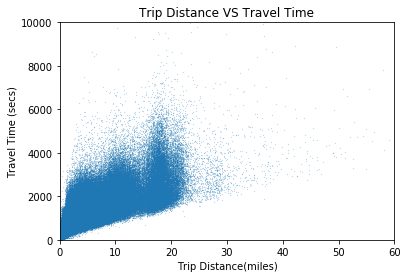

In [21]:
plt.scatter(Final_Cleaned_Data['trip_distance'],Final_Cleaned_Data['travel_time'],s=0.01)
plt.ylim(0,10000)
plt.xlim(0,60)
plt.title('Trip Distance VS Travel Time')
plt.ylabel('Travel Time (secs)')
plt.xlabel('Trip Distance(miles)')
plt.show()

We further clustered pickup and dropoff locations through Kmeans function, setting number of cluster = 15, which automatically divided locations in pickup and dropoff into 15 clusters. Additionally, we categorized each record into a unique route. For example, route_2to3 means a trip from zone 2 in pickup to zone 3 in dropoff. 

In [93]:
df = Final_Cleaned_Data

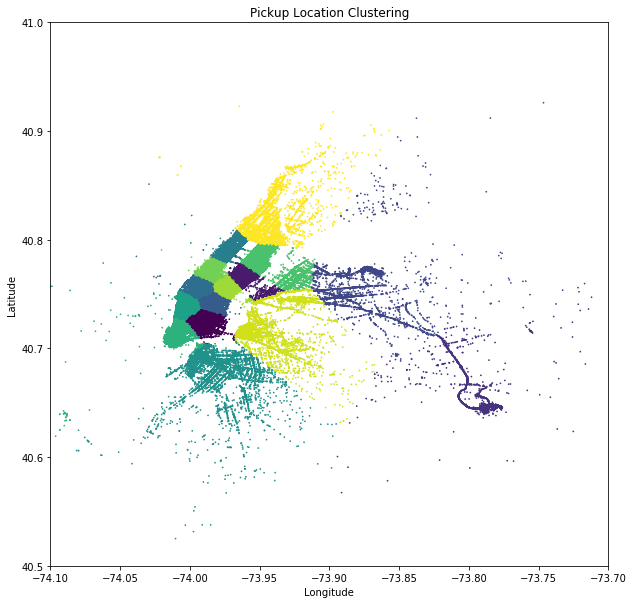

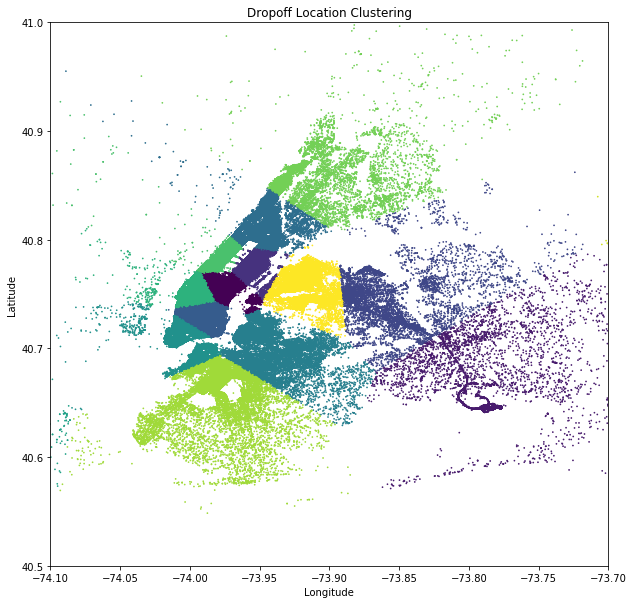

In [94]:
#clustering pickup and dropoff locations
from sklearn.cluster import KMeans

n = len(df)
kmeans_pickup = KMeans(n_clusters = 15, random_state = 2).fit(df[['pickup_latitude', 'pickup_longitude']])
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
plt.figure(figsize=(10,10))
plt.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n],
            s = 0.5)
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.1,-73.7)
plt.ylim(40.5,41)
plt.show()

kmeans_dropoff = KMeans(n_clusters = 15, random_state = 2).fit(df[['dropoff_latitude', 'dropoff_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])
plt.figure(figsize=(10,10))
plt.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n],
           s = 0.5)
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.1,-73.7)
plt.ylim(40.5,41)
plt.show()

## Convert categorical features into one hot encoded dummy variables

In [106]:
df['pickup_dropoff_cluster'] = df['kmeans_pickup'].map(str) + 'to' +  df['kmeans_dropoff'].map(str)
df = pd.concat([df, pd.get_dummies(df['pickup_dropoff_cluster'], prefix = 'route')], axis = 1)
df1 = df.copy()

## 4. EDA Through Tableau

Below shows the dashboard created using our cleaned data discussed earlier. It is an interactive tool that tracks yellow cab rides in year 2016. One can click on the plots and points to filter the data and thus see more detailed information regarding the rides. 

The first graph demonstrates the frequency of trips by pickup hour and day of week. From the graph we see that the trend of trip frequencies are similar except for Sunday, where the most trips happened during midnight after Saturday. For the rest of the week, fewer rides occurred in late nights and early mornings, and most rides happened between 6 and 10 p.m.

Below the frequency of trips graph shows the map of New York City with trip distance (in miles) and trip duration (in minutes) by hour of day. The red points in the left map marks the pickup locations of rides with distance above 75% of the data. Similarly, the red points in the right map labels the pickup locations of rides with travel time above 75% of the data. From both maps we see that the most of the rides departing from the airports (JFK and LGA) have longer distance and travel time.

Further down, we see the average trip duration in minutes, average trip distance in miles, and average speed (mph) by hour of day. We observed that the trips in early mornings and late nights are relatively longer but completed in less time. Such could result from the fact the traffic is less in early mornings and people prefer to cab. On the contrary, people might opt to take subway instead to avoid traffic during rush hours.

We also observed that average trip duration is the highest between 4 to 5 p.m., which is also when the lowest average speed occured. This could be that there are in general less trips, as shown in the total trips by hour graph on the right hand side. We learned that 4 - 5 p.m. serves as the traditional hour for yellow taxis to change shifts, and the number of active taxi cabs on the streets falls as a result. In terms of ride speed, average speed is apparently lower during the day, mostly because of the busy traffic.

From the Histogram of Trip Duration we see that most trips last 6 minutes. The density resembles a log-normal distribution as trip duration cannot be negative. The Total Trip by Hour graph once again showed that most rides happened between 6 and 10 pm, and 4 p.m. is when there are fewest rides during the day time between 8 a.m. and 11 p.m., which is consistent with the discussion above.


In [336]:
%%HTML

<div class='tableauPlaceholder' id='viz1558042209343' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;NY&#47;NYCTaxiv7&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='NYCTaxiv7&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;NY&#47;NYCTaxiv7&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1558042209343');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='1527px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='1527px';} else { vizElement.style.width='100%';vizElement.style.height='2077px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>


In [61]:
df_check = df.drop(['pickup_datetime', 'dropoff_datetime','pickup_dropoff_cluster','vendor_id',  'trip_distance', 'pickup_longitude', 'pickup_latitude', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude','kmeans_pickup','kmeans_dropoff','mta_tax','imp_surcharge','datetime'], axis = 1)
df_check = df_check.drop(df.columns[[0]],axis=1)

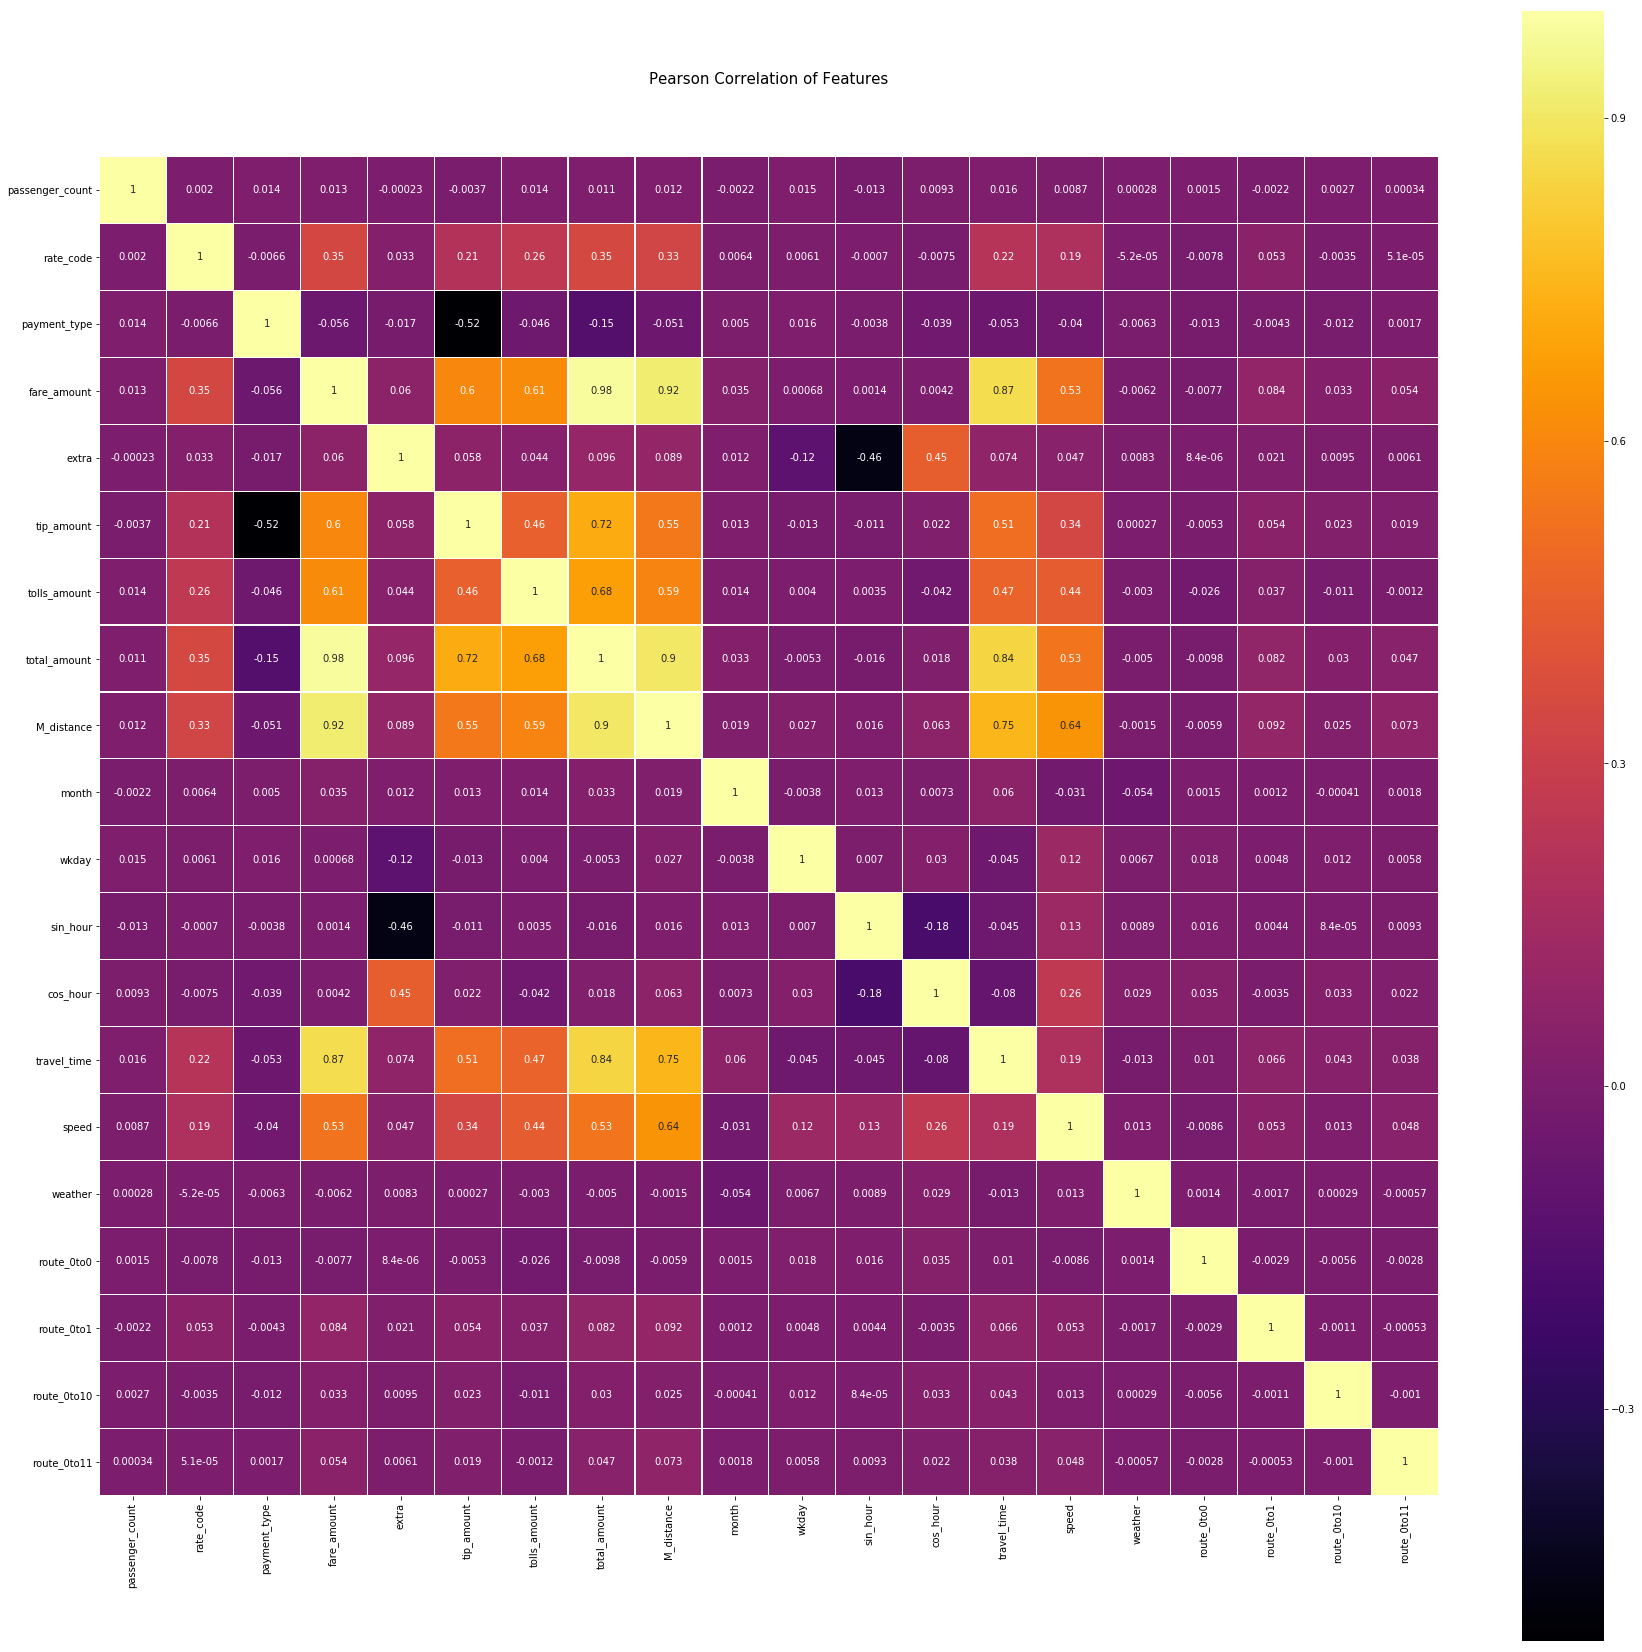

In [62]:
import seaborn as sns
#Check correlation
col_filter = list(df_check.columns.values)[0:20]
colormap = plt.cm.inferno
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_check[col_filter].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

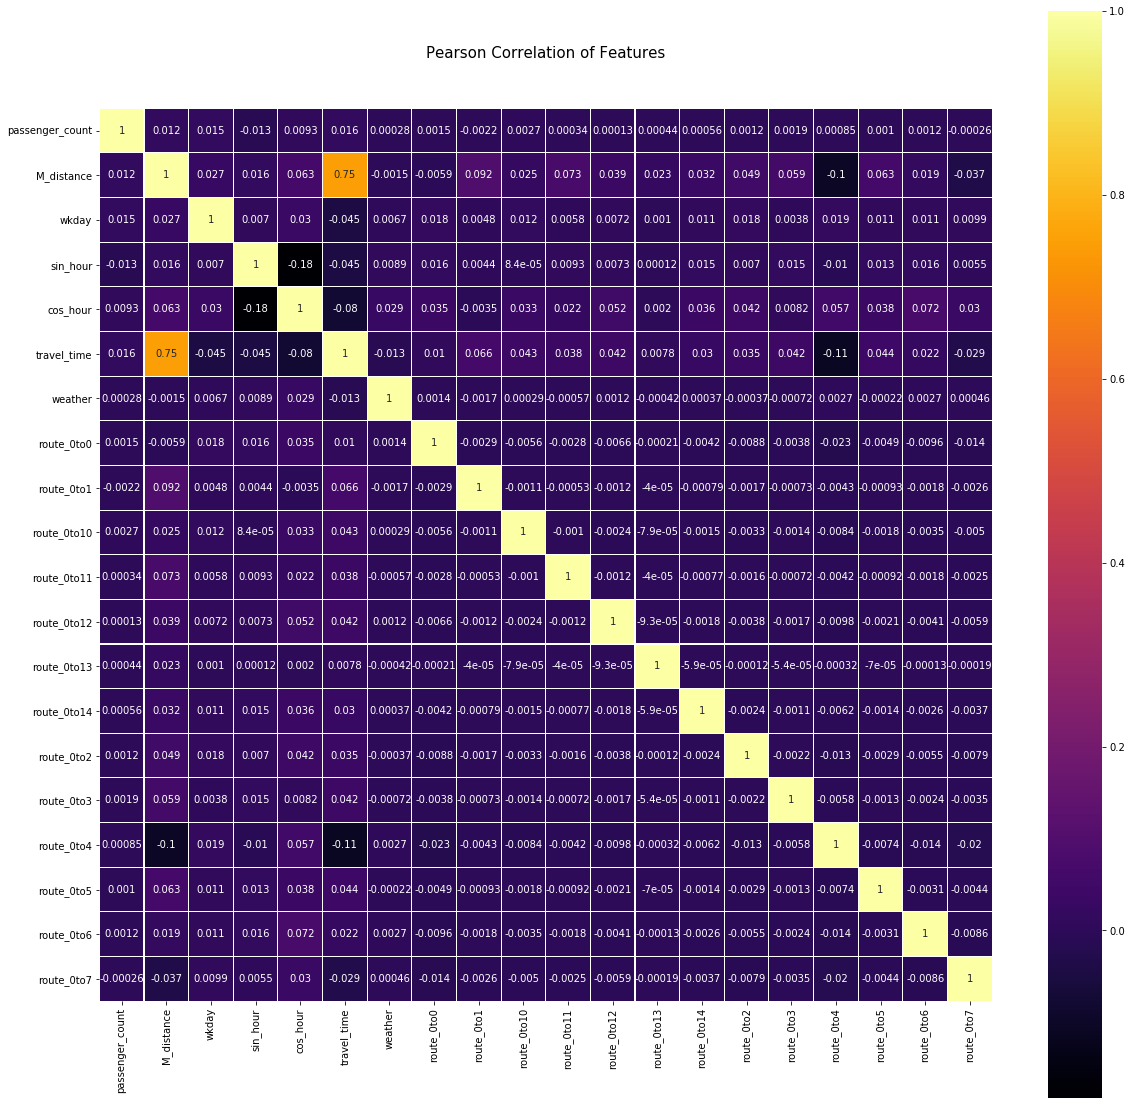

In [63]:
df_check = df_check.drop(['rate_code', 'fare_amount','extra', 'tip_amount','tolls_amount','total_amount','speed','payment_type','month'], axis = 1)
col_filter = list(df_check.columns.values)[0:20]
colormap = plt.cm.inferno
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_check[col_filter].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [187]:
#df = df_check
df = pd.read_csv('FINAL_DF.csv')
#df.to_csv('FINAL_DF.csv')

## 5.Train the Model

In [189]:
#df.to_csv('FINAL_DF.csv')
df.head()

,Unnamed: 0,passenger_count,M_distance,wkday,sin_hour,cos_hour,travel_time,weather,route_0to0,route_0to1,...,route_9to13,route_9to14,route_9to2,route_9to3,route_9to4,route_9to5,route_9to6,route_9to7,route_9to8,route_9to9
0,0,1,1.027566,1,-1.0,-1.836970e-16,450.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,10.815612,1,-1.0,-1.836970e-16,2048.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1.746597,1,-1.0,-1.836970e-16,487.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0.637569,1,-1.0,-1.836970e-16,358.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,5.464020,1,-1.0,-1.836970e-16,1246.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
df_X = df.drop(['Unnamed: 0','travel_time'],axis=1)
df_X.head()

,passenger_count,M_distance,wkday,sin_hour,cos_hour,weather,route_0to0,route_0to1,route_0to10,route_0to11,...,route_9to13,route_9to14,route_9to2,route_9to3,route_9to4,route_9to5,route_9to6,route_9to7,route_9to8,route_9to9
0,1,1.027566,1,-1.0,-1.836970e-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10.815612,1,-1.0,-1.836970e-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.746597,1,-1.0,-1.836970e-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.637569,1,-1.0,-1.836970e-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,5.464020,1,-1.0,-1.836970e-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
X = np.array(df_X)
y = np.array(df['travel_time'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
X_scaled = preprocessing.scale( np.array(df.drop(['travel_time','weather'], 1)))
y_scaled = preprocessing.scale( np.array(df['travel_time']))
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.2)

## 6.Make predictions
## Linear Regression

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression(fit_intercept=False)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print('Coefficients: \n', regr.coef_)
print('R^2 on training data is',regr.score(X_train,y_train))
print('R^2 on testing data is',regr.score(X_test,y_test))

Coefficients: 
 [ 3.89251400e+00  1.55654591e+02 -1.23838220e+02 -9.28333584e+01
 -1.57562289e+02  5.10279178e+02  2.88961096e+02  8.36240594e+02
  6.68705028e-01  6.57780952e+02 -3.46559814e+03  6.37481426e+02
  4.42219628e+02  3.87521049e+02  3.14353136e+02  4.47468992e+02
  5.74822381e+02  4.20475189e+02  2.45985067e+02  5.66831734e+02
  4.48295089e+02 -4.15972910e+02  3.29928999e+02  1.68470239e+02
  6.31913707e+02  6.83089568e+02  3.99844482e+02  1.68672987e+02
  4.15597415e+02  4.08137344e+02  2.35907146e+02  7.93562926e+02
  2.18034841e+02 -9.95410485e+01  7.07111931e+02  3.97418347e+02
  2.71839519e+01  1.71914709e+02 -1.41569549e+02  1.10417054e+03
 -5.25168744e+01  7.23810799e+02  4.59967815e+02  8.90064040e+02
  7.63980975e+02  2.31439493e+02  1.05871610e+03  6.99666495e+02
 -1.07574790e+02  4.20632317e+02  3.12828748e+02 -4.59681475e+01
  4.95163330e+02  4.92815015e+01  8.77652037e+02 -1.02379218e+03
  6.49575545e+02  2.65184970e+02  5.62640179e+02  4.08171322e+02
  4.05665

## Plot clusters by coefficient values
- After obtaining the coefficients from linear regression model, we matched the coefficient for each unique route back to the dataset to visualize the clusters. The deeper the color is, the more positive the coefficient is. 
- For pickup locations, points around Laguadia Airports appeared to be deeper colors, meaning that trips departing from Laguadia resulted in a longer travel period. 
- For dropoff locations, points in Brooklyn area are deeper in color which means trips ending in Brooklyn lasted longer.


In [107]:
names = list(df1.columns.values)[32:]
names = list(i[6:] for i in names)
coes = regr.coef_[5:]
df1.pickup_dropoff_cluster.replace(names, coes, inplace=True)

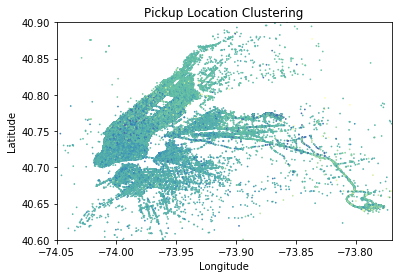

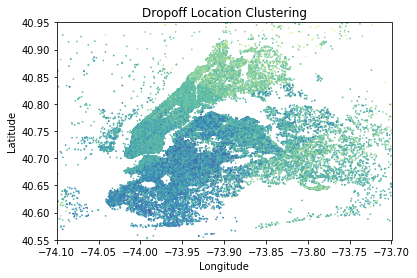

In [109]:
plt.scatter(df1.pickup_longitude[:n], 
            df1.pickup_latitude[:n],
            cmap = 'Spectral',
            c = df1.pickup_dropoff_cluster[:n], s = 0.5)
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05,-73.77)
plt.ylim(40.6,40.9)
plt.show()
plt.scatter(df1.dropoff_longitude[:n], 
            df1.dropoff_latitude[:n],
            cmap = 'Spectral',
            c = df1.pickup_dropoff_cluster[:n], s = 0.5)
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.1,-73.7)
plt.ylim(40.55,40.95)
plt.show()


## Lasso Model

In [ ]:
lasso = Lasso()
alphas = np.linspace(0.01,1,11)
lasso_r_score = []
index = range(11)
for i in range(len(alphas)):
    lassoreg = Lasso(alpha=alphas[i])
    lassoreg.fit(X_train,y_train)
    y_lasso_pred = lassoreg.predict(X_test)
    lasso_r_score.append(lassoreg.score(X_test,y_test))
plt.scatter(index,lasso_r_score)

best_alpha_index = lasso_r_score.index(max(lasso_r_score))
lassoreg = Lasso(alpha=alphas[best_alpha_index])
lassoreg.fit(X_train,y_train)
y_lasso_pred = lassoreg.predict(X_test)
lasso_r_score.append(lassoreg.score(X_test,y_test))

print(lassoreg.coef_)
print('Lasso_R^2',lassoreg.score(X_test,y_test))

## Plot clusters by coefficient values
- For lasso model, we chose a different colormap. Green represent The deeper the color is, the more positive the coefficient is. 
- For pickup locations, points around Laguadia Airports appeared to be deeper colors, meaning that trips departing from Laguadia resulted in a longer travel period. 
- For dropoff locations, points in Brooklyn area are deeper in color which means trips ending in Brooklyn lasted longer.


In [102]:
coes_lasso = lassoreg.coef_[5:]
df1.pickup_dropoff_cluster.replace(coes, coes_lasso, inplace=True)

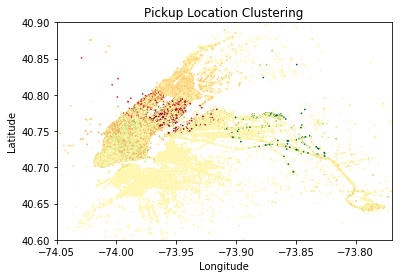

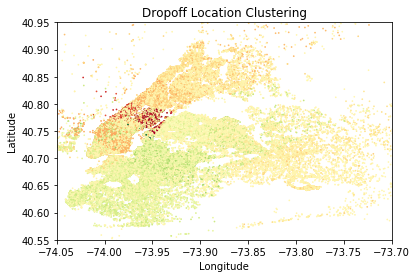

In [103]:
plt.scatter(df1.pickup_longitude[:n], 
            df1.pickup_latitude[:n],
            cmap = 'RdYlGn',
            c = df1.pickup_dropoff_cluster[:n], s = 0.5)
plt.title('Pickup Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05,-73.77)
plt.ylim(40.6,40.9)
plt.show()
plt.scatter(df1.dropoff_longitude[:n], 
            df1.dropoff_latitude[:n],
            cmap = 'RdYlGn',
            c = df1.pickup_dropoff_cluster[:n], s = 0.5)
plt.title('Dropoff Location Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.05,-73.7)
plt.ylim(40.55,40.95)
plt.show()



# Lasso with parameter tuning and CV

In [255]:
def error_measure(y_test,y_pred):
    RMSE =np.sqrt(mean_squared_error(y_test,y_pred))
#     RMSLE=np.sqrt(mean_squared_log_error(y_test,y_pred))
    R_score = r2_score(y_test,y_pred)
    return pd.DataFrame({'RMSE:':[RMSE],'R2:':[R_score]})


/local_mount/space/dingus/1/Weihao/anaconda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/local_mount/space/dingus/1/Weihao/anaconda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


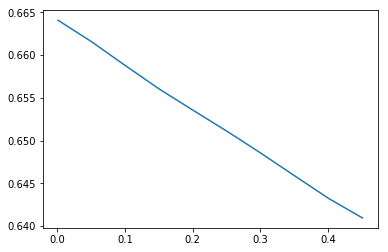

In [252]:
alphas = np.arange(0.001,0.5,0.05)
lasso_r2_score = []

for i in alphas:
    lasso = Lasso(alpha=i)
    scores = cross_validate(lasso, X, y, cv=3,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    lasso_r2_score = np.append(lasso_r2_score ,np.mean(scores['train_r2']))

                     
plt.plot(alphas,lasso_r2_score)

Select the alpha with the best R2, which is 0.001

In [256]:
lasso1 = Lasso(alpha=0.001)
lasso1.fit(X_train,y_train)
y_lasso_pred = lasso1.predict(X_test)
lasso_score = error_measure(y_test,y_lasso_pred)
lasso_score

,RMSE:,nR2:
0,391.840383,0.653084


In [262]:

print("Answer to the bonus question:",
      "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximizing the generalization score on different")
print("subsets of the data:")

print("Answer: Not very much since we obtained different alphas for different")
print("subsets of the data and moreover, the scores for these alphas differ")
print("quite substantially.")


Answer to the bonus question: how much can you trust the selection of alpha?

Alpha parameters maximizing the generalization score on different
subsets of the data:
Answer: Not very much since we obtained different alphas for different
subsets of the data and moreover, the scores for these alphas differ
quite substantially.


## Ridge with parameter tuning and CV

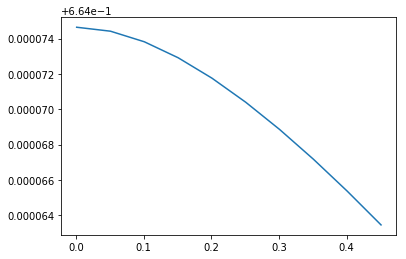

In [261]:
lam = np.arange(0.001,0.5,0.05)
ridge_r2_score = []

for i in lam:
    ridge = Ridge(alpha=i)
    scores = cross_validate(ridge, X, y, cv=3,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    ridge_r2_score = np.append(ridge_r2_score ,np.mean(scores['train_r2']))

                     


Select the alpha with the best R2, which is 0.001

In [266]:
ridge1 = Ridge(alpha=0.001)
ridge1.fit(X_train,y_train)
y_ridge_pred = ridge1.predict(X_test)
ridge_score = error_measure(y_test,y_ridge_pred)
ridge_score

,RMSE:,nR2:
0,391.856432,0.653056


# GridSearchCV Random Forest

In [202]:
def error_measure(y_test,y_pred):
    RMSE =np.sqrt(mean_squared_error(y_test,y_pred))
    RMSLE=np.sqrt(mean_squared_log_error(y_test,y_pred))
    R_score = r2_score(y_test,y_pred)
    return pd.DataFrame({'RMSE:':[RMSE],'nRMSLE:':[RMSLE],'nR2:':[R_score]})



rfc=RandomForestRegressor(random_state=42)
param_grid = { 
    'n_estimators': [50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,8],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)



{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}


In [203]:
rfc1=RandomForestRegressor(random_state=42, max_features=CV_rfc.best_params_['max_features'],
                            n_estimators= CV_rfc.best_params_['n_estimators'], 
                            max_depth=CV_rfc.best_params_['max_depth'])
rfc1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [235]:
pred=rfc1.predict(X_test)
# print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))
print("Error for GridSearchCV Random Forest: ")
rf_score = error_measure(y_test,pred)
rf_score

Error for GridSearchCV Random Forest: 


,RMSE:,nRMSLE:,nR2:
0,379.012907,0.429881,0.675426


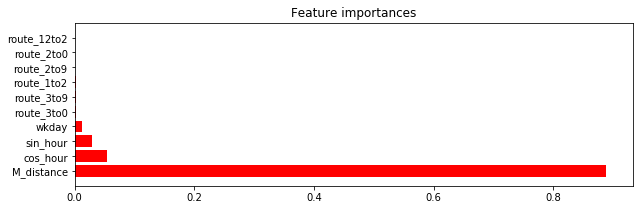

In [230]:
importances = rfc1.feature_importances_
std = np.std([rfc1.feature_importances_ for tree in rfc1.estimators_],
             axis=0)
hello = np.argsort(-importances)
indices = hello[:10]
plt.figure(figsize=(10,3))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(indices)), df_X.columns[indices])
plt.ylim([-1, len(indices)])
plt.show()

# GridSearchCV Gradient Boosting

In [237]:
parameters = {
    "loss":["ls"],
    "learning_rate": [0.01, 0.05,0.1, 0.15],
    "min_samples_split": np.linspace(0.1, 1, 12),
    "max_depth":[3,6],
    "max_features":["log2","sqrt"],
    "n_estimators":[10]
    }

CV_clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=3, n_jobs=-1)

CV_clf.fit(X_train, y_train)
print(CV_clf.score(X_train, y_train))
print(CV_clf.best_params_)


0.3959258831796804
{'learning_rate': 0.15, 'loss': 'ls', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 0.34545454545454546, 'n_estimators': 10}


In [239]:

clf1.fit(X_train, y_train)
pred=clf1.predict(X_test)
# print("Accuracy for GB on CV data: ",accuracy_score(y_test,pred))
print("Error for GB on CV data: ")
gb_score = error_measure(y_test,pred)
gb_score

Error for GB on CV data: 


,RMSE:,nRMSLE:,nR2:
0,526.293542,0.644939,0.374162


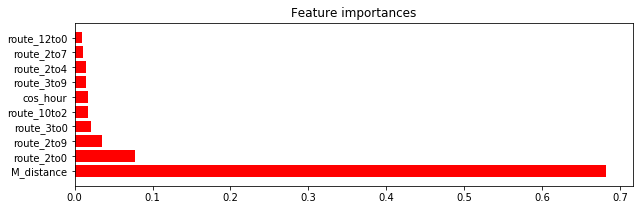

In [273]:
importances = clf1.feature_importances_
std = np.std([clf1.feature_importances_ for tree in clf1.estimators_],
             axis=0)
hello = np.argsort(-importances)
indices = hello[:10]
plt.figure(figsize=(10,3))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(indices)), df_X.columns[indices])
plt.ylim([-1, len(indices)])
plt.show()

## Model Comparision Plots

In [269]:
# Compare model performances
#linear_scores = pd.DataFrame({'RMSE':[350], 'R2':[0.72]})
#rf_scores = pd.DataFrame({'RMSE':[280], 'R2':[0.72]})
#gb_scores = pd.DataFrame({'RMSE':[210], 'R2':[0.78]})
#lasso_scores = pd.DataFrame({'RMSE':[430], 'R2':[0.68]})
combined_scores = pd.concat([ridge_score, rf_score, gb_score, lasso_score])
model_names = ['Ridge','Random_Forest','Gradient Boosting','Lasso']
combined_scores.index = model_names
combined_scores

/local_mount/space/dingus/1/Weihao/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,RMSE:,nR2:,nRMSLE:
Ridge,391.856432,0.653056,NaN
Random_Forest,379.012907,0.675426,0.429881
Gradient Boosting,526.293542,0.374162,0.644939
Lasso,391.840383,0.653084,NaN


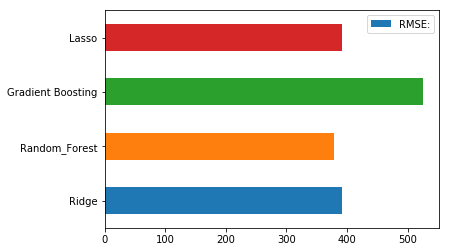

In [271]:
combined_scores['RMSE:'].plot.barh(align='center',legend=True)

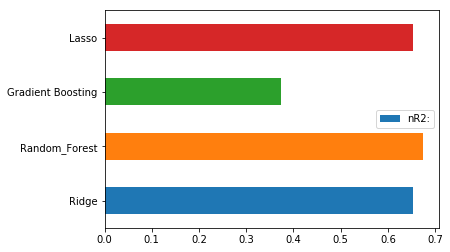

In [272]:
combined_scores['nR2:'].plot.barh(align='center',legend=True)

So we select random forest model to predict test data set!

## Test data prediction

In [328]:
final_pred=rfc1.predict(df_final)

In [333]:
df_final['predicted travel time'] =final_pred

In [334]:
df_final.head()

,passenger_count,M_distance,wkday,sin_hour,weather,cos_hour,route_0to0,route_0to1,route_0to10,route_0to11,...,route_9to14,route_9to2,route_9to3,route_9to4,route_9to5,route_9to6,route_9to7,route_9to8,route_9to9,predicted travel time
0,5.0,5.997238,0,-0.707107,0,7.071068e-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1642.423924
1,1.0,10.347613,1,0.500000,0,8.660254e-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1514.245886
2,1.0,6.837375,0,0.866025,0,5.000000e-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1291.665547
3,2.0,7.771625,0,0.707107,0,-7.071068e-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1301.489440
4,2.0,0.211063,0,-1.000000,0,-1.836970e-16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,281.317958


In [335]:
df_final.to_csv('this_is_final_test_prediction.csv')

## Next Steps

Even more data cleaning: we noticed from our data set that few pickup and dropoff points provided are located in the river area on the map. A next step would be looking at the angles of the pickup locations and see if transforming the angles would increase the feature’s correlation with travel time and the prediction performance. 
An intuition would be to use Google Maps API to obtain an expected travelling distance and time for the trip to see if such would help us with making better travel time predictions
